In [84]:
import keras.applications.efficientnet_v2
import tensorflow as tf
from keras import layers, Sequential

In [85]:
IMAGE_SIZE=(224, 224)
train_dir = "datasets/10_food_classes_10_percent/train/"
test_dir = "datasets/10_food_classes_10_percent/test/"

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMAGE_SIZE, batch_size=32, label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMAGE_SIZE, batch_size=32, label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [86]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [87]:
preprocess_img = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    #layers.Rescaling(1./255) # only for resnet
], name="Data_Augmentation")

(-0.5, 511.5, 511.5, -0.5)

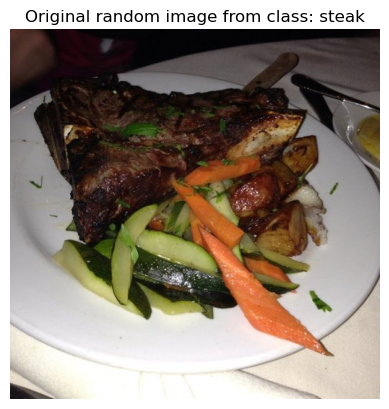

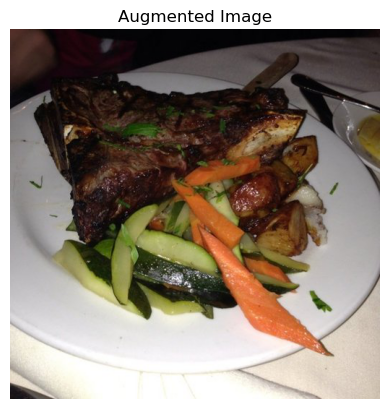

In [88]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

train_class = random.choice(os.listdir("datasets/10_food_classes_10_percent/train/"))
train_dir = "datasets/10_food_classes_10_percent/train/" + train_class
random_img = "datasets/10_food_classes_10_percent/train/" + train_class + "/" +random.choice(os.listdir(train_dir))
img = mpimg.imread(random_img)
plt.imshow(img)
plt.title(f"Original random image from class: {train_class}")
plt.axis(False)

# pass through data aug model
aug_img = preprocess_img(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(aug_img)/255.)
plt.title("Augmented Image")
plt.axis(False)

In [89]:
# Creating a function to generate a TensorBoard callback
import datetime
from keras.callbacks import TensorBoard

def create_tensorboard(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to: {log_dir}")
    return tensorboard_callback


In [90]:
INPUT_SHAPE = (224, 224, 3)
# EfficientNetV3B3
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# Freeze layers
base_model.trainable = False

# Create the input Tensor
input_tensor = layers.Input(shape=INPUT_SHAPE,
                            name="Input")

# create the augmentation layer
x = preprocess_img(input_tensor)

# pass augmented inputs to Model
x = base_model(x)

# Avg Pooling
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# create the output layer
output_tensor = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create the model with Inputs and Outputs
model_1 = tf.keras.Model(input_tensor, output_tensor)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_1 = model_1.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data),
                        callbacks=[create_tensorboard("transfer_learning", "1_percent_data_aug")])


Saving Tensorboard log files to: transfer_learning/1_percent_data_aug/20230930-121041
Epoch 1/5
24/24 [==============================] - 34s 858ms/step - loss: 2.0455 - accuracy: 0.2867 - val_loss: 1.5394 - val_accuracy: 0.5976
Epoch 2/5
24/24 [==============================] - 16s 689ms/step - loss: 1.4395 - accuracy: 0.6120 - val_loss: 1.1079 - val_accuracy: 0.7448
Epoch 3/5
24/24 [==============================] - 18s 730ms/step - loss: 1.1555 - accuracy: 0.7267 - val_loss: 0.9193 - val_accuracy: 0.7704
Epoch 4/5
24/24 [==============================] - 17s 719ms/step - loss: 0.9961 - accuracy: 0.7360 - val_loss: 0.7835 - val_accuracy: 0.8028
Epoch 5/5
24/24 [==============================] - 18s 745ms/step - loss: 0.8973 - accuracy: 0.7627 - val_loss: 0.7055 - val_accuracy: 0.8112


In [91]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [92]:
results_1 = model_1.evaluate(test_data)
results_1

79/79 [==============================] - 6s 78ms/step - loss: 0.7055 - accuracy: 0.8112


[0.7055296897888184, 0.8112000226974487]

In [93]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']

    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].plot(epochs, loss, label="loss")
    ax[0].plot(epochs, val_loss, label="val_loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(epochs, accuracy, label="accuracy")
    ax[1].plot(epochs, val_accuracy, label="val_accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    plt.show()

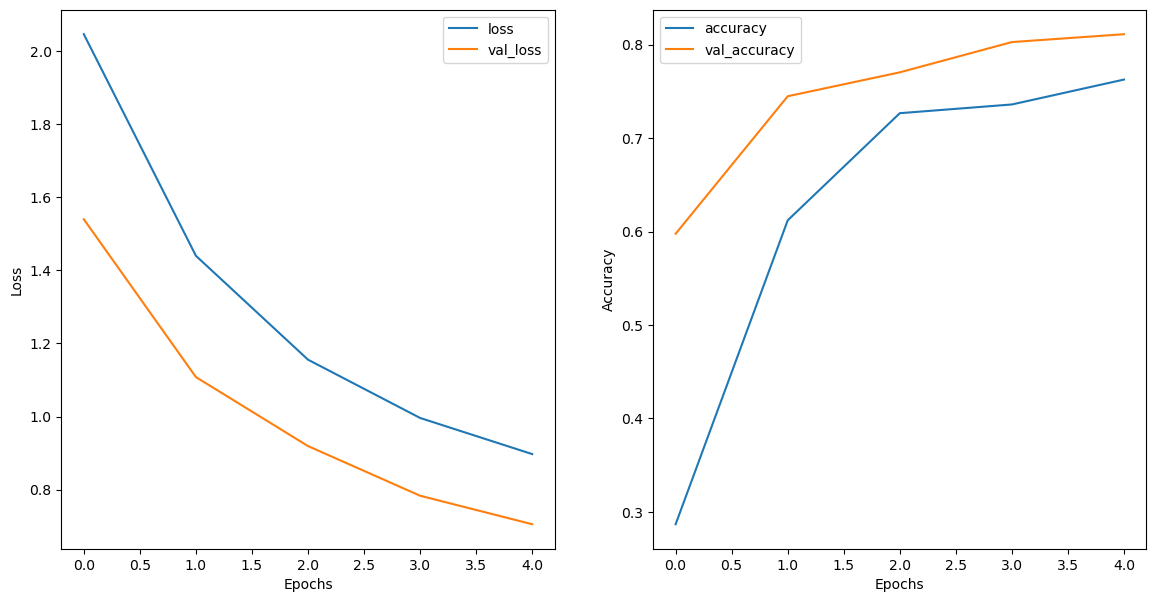

In [94]:
plot_loss_curves(history_1)


# Training with Model Checkpoints

In [95]:
base_model_2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)

base_model_2.trainable = False
input = layers.Input(shape=INPUT_SHAPE)
x = preprocess_img(input)
x = base_model_2(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = layers.Dense(10, activation='softmax', name="output_layer")(x)

model_2 = keras.Model(input, output)

model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


In [96]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = preprocess_img(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [97]:
checkpoint_path = 'model_checkpoints/10_percent/'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      save_freq='epoch',
                                                      save_best_only=True,
                                                      verbose=1)
initial_epochs = 5

In [98]:
history_2 = model_2.fit(train_data, epochs=initial_epochs, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=0.25*len(test_data), callbacks=[create_tensorboard("transfer_learning", "model checkpoint test"), checkpoint_callback])

Saving Tensorboard log files to: transfer_learning/model checkpoint test/20230930-121242
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0118 - accuracy: 0.3187
Epoch 1: val_loss improved from inf to 1.52219, saving model to model_checkpoints/10_percent\
24/24 [==============================] - 31s 808ms/step - loss: 2.0118 - accuracy: 0.3187 - val_loss: 1.5222 - val_accuracy: 0.6484
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4018 - accuracy: 0.6267
Epoch 2: val_loss improved from 1.52219 to 1.11709, saving model to model_checkpoints/10_percent\
24/24 [==============================] - 15s 608ms/step - loss: 1.4018 - accuracy: 0.6267 - val_loss: 1.1171 - val_accuracy: 0.7563
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.7280
Epoch 3: val_loss improved from 1.11709 to 0.85638, saving model to model_checkpoints/10_percent\
24/24 [==============================] - 15s 627ms/step - loss: 1.1124 - accur

In [99]:
results_2 = model_2.evaluate(test_data)
results_2

79/79 [==============================] - 7s 81ms/step - loss: 0.6667 - accuracy: 0.8248


[0.6667410135269165, 0.8248000144958496]

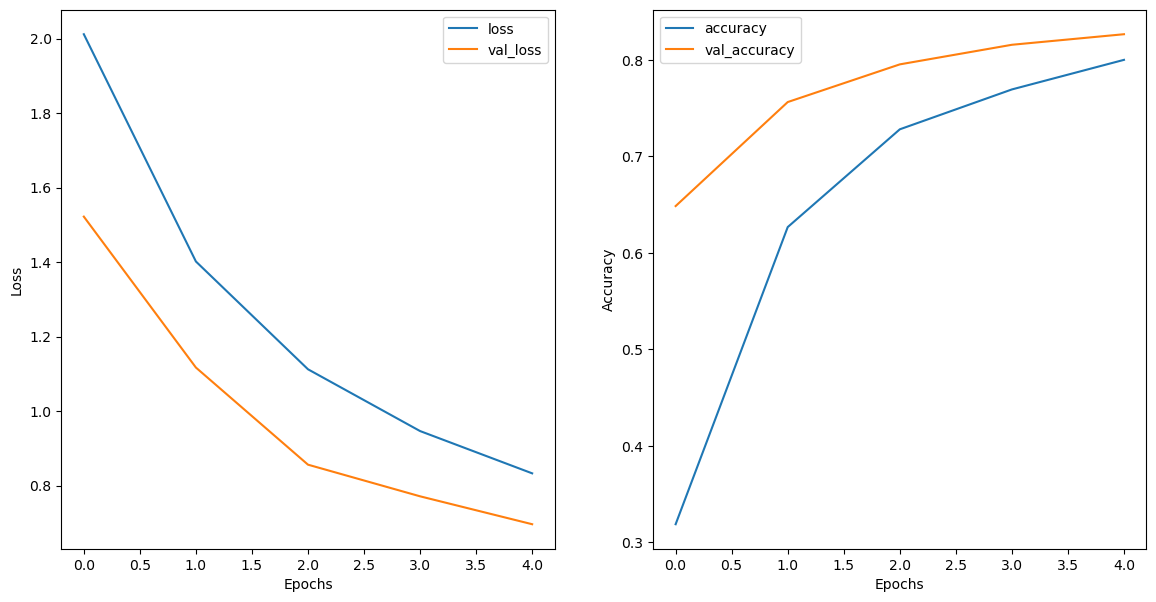

In [100]:
plot_loss_curves(history_2)

In [101]:
model_2.load_weights(checkpoint_path)

In [102]:
results_loaded = model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.6667 - accuracy: 0.8248


In [103]:
results_2 == results_loaded

False

In [104]:
model_2.layers


In [105]:
for layer_number, layer in enumerate(model_2.layers):
    print(f"Layer number: {layer_number} | Layer Name: {layer.name} | Layer type: {layer} | is Trainable?: {layer.trainable}")

Layer number: 0 | Layer Name: input_layer | Layer type: <keras.engine.input_layer.InputLayer object at 0x000001FDBC54B3D0> | is Trainable?: True
Layer number: 1 | Layer Name: Data_Augmentation | Layer type: <keras.engine.sequential.Sequential object at 0x000001FBBA912910> | is Trainable?: True
Layer number: 2 | Layer Name: efficientnetv2-b0 | Layer type: <keras.engine.functional.Functional object at 0x000001FDBC579D90> | is Trainable?: False
Layer number: 3 | Layer Name: global_average_pooling_layer | Layer type: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001FDBC5730A0> | is Trainable?: True
Layer number: 4 | Layer Name: output_layer | Layer type: <keras.layers.core.dense.Dense object at 0x000001FDBC548BB0> | is Trainable?: True


In [106]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [107]:
model_2.layers[2].trainable_variables

[]

In [108]:
trainable_count = 0
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer, layer.trainable)
    trainable_count = trainable_count + 1 if layer.trainable else trainable_count

print(trainable_count)

0 <keras.engine.input_layer.InputLayer object at 0x000001FDB2B772B0> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001FDB2B77070> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x000001FDBBD176D0> False
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001FDB2B1F160> False
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001FDB12162E0> False
5 <keras.layers.core.activation.Activation object at 0x000001FDBBD64E80> False
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001FDBC19F430> False
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001FDBC19F0D0> False
8 <keras.layers.core.activation.Activation object at 0x000001FDBC178430> False
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001FDBC19F220> False
10 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001FDBC1B0850> False
11 <keras.layers.core

In [109]:
# To fine tune, first we unfreeze the model in general by setting the trainable to True
model_2.layers[2].trainable = True

# the we loop through the layers of the layer[2] (which is the base model) and freeze every layer but the last 10
for layer in model_2.layers[2].layers[:-10]:
    layer.trainable = False

# Now we compile the new model 
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy']) # lr is 10x lower than before to avoid "forgetting" useful features

In [110]:
model_2.layers[2].trainable_variables

[<tf.Variable 'block6h_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.00207604,  0.01300672,  0.02047416, ..., -0.02240255,
           -0.07708141, -0.00094655],
          [-0.06357138,  0.0959678 , -0.05430871, ..., -0.01352078,
           -0.05987524, -0.11093444],
          [ 0.0068749 , -0.04681807, -0.01513974, ...,  0.03073284,
           -0.01280731,  0.03616464],
          ...,
          [ 0.11381665,  0.00804447, -0.05432149, ...,  0.08015257,
           -0.06561387, -0.05522665],
          [-0.12468243,  0.06938899, -0.07634895, ...,  0.01121222,
           -0.0128268 ,  0.10406019],
          [-0.04722364,  0.10557885,  0.16247186, ...,  0.04582691,
            0.01228108, -0.04941604]]]], dtype=float32)>,
 <tf.Variable 'block6h_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([ 0.04594925,  2.5461788 , -1.426646  , -0.7885664 , -0.24730209,
        -0.5630991 , -0.6161863 , -0.4029834 , -1.4444699 , -1.0481553 ,
        -0.21704195,

In [111]:
len(model_2.layers[2].trainable_variables), len(model_2.trainable_variables)

(10, 12)

In [112]:
# Since we already trained the model_2 fr 5 epochs before compiling with the new layers, let's begin fine tuning from the last epoch 
history_3 = model_2.fit(train_data, epochs=initial_epochs + 5, initial_epoch=history_2.epoch[-1], validation_data=test_data, steps_per_epoch=len(train_data), validation_steps=int(0.25*len(test_data)), callbacks=[create_tensorboard("transfer_learning", "10_percent_fine_tuning")])

Saving Tensorboard log files to: transfer_learning/10_percent_fine_tuning/20230930-121432
Epoch 5/10
24/24 [==============================] - 30s 734ms/step - loss: 0.7255 - accuracy: 0.8027 - val_loss: 0.5328 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 15s 618ms/step - loss: 0.5861 - accuracy: 0.8360 - val_loss: 0.4887 - val_accuracy: 0.8470
Epoch 7/10
24/24 [==============================] - 14s 593ms/step - loss: 0.5630 - accuracy: 0.8320 - val_loss: 0.4447 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 15s 608ms/step - loss: 0.5046 - accuracy: 0.8333 - val_loss: 0.5082 - val_accuracy: 0.8405
Epoch 9/10
24/24 [==============================] - 13s 549ms/step - loss: 0.4639 - accuracy: 0.8533 - val_loss: 0.4540 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 15s 625ms/step - loss: 0.4351 - accuracy: 0.8653 - val_loss: 0.4533 - val_accuracy: 0.8536


In [113]:
results_fine_tuning_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 78ms/step - loss: 0.4444 - accuracy: 0.8512


In [114]:
def compare_history(original_history, new_history, initial_epochs=5):
    acc = original_history.history['accuracy']
    val_acc = original_history.history['val_accuracy']
    
    loss = original_history.history['loss']
    val_loss = original_history.history['val_loss']

    # concat measurements
    
    total_acc = acc + new_history.history['accuracy']
    total_val_acc = val_acc + new_history.history['val_accuracy']
    
    total_loss = loss + new_history.history['loss']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs, initial_epochs], plt.ylim(), label="start fine tuning")
    plt.legend(loc="lower right")
    
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs, initial_epochs], plt.ylim(), label="start fine tuning")
    plt.legend()
    
    plt.show()
    
    

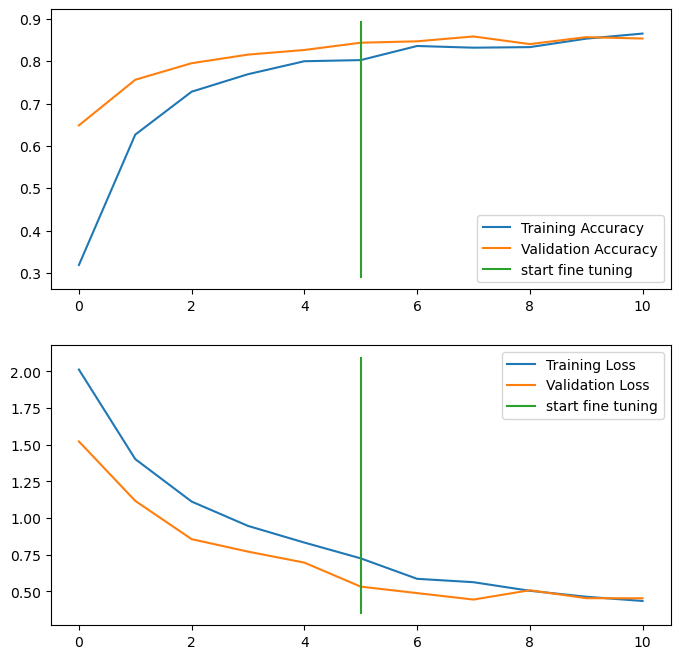

In [115]:
compare_history(history_2, history_3)

# Training on all the data now (scaling up)

In [121]:
# Setup data directories
train_dir_full = "datasets/10_food_classes_all_data/train/"
test_dir_full = "datasets/10_food_classes_all_data/test/"

In [118]:
model_3 = create_base_model(INPUT_SHAPE, 10) 

In [123]:
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_full, image_size=IMAGE_SIZE, batch_size=32, label_mode="categorical")
test_data_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir_full, image_size=IMAGE_SIZE, batch_size=32, label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## let's first evaluate on previous model with 10%

In [124]:
model_2.evaluate(test_data_full)

79/79 [==============================] - 6s 73ms/step - loss: 0.4444 - accuracy: 0.8512


[0.44438785314559937, 0.8511999845504761]

In [128]:
# check if they are same
results_fine_tuning_10_percent

[0.44438788294792175, 0.8511999845504761]

In [129]:
#load weights from previous checkpoint to keep experiments consistent
model_3.load_weights(checkpoint_path)

In [130]:
model_3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [131]:
print(len(model_3.layers[2].trainable_variables))

0


In [134]:
# Freeze everything but last 10 

model_3.trainable = True
for layer in model_3.layers[2].layers[:-10]:
    layer.trainable = False

In [136]:
print(len(model_3.layers[2].trainable_variables))

10


In [137]:
# compile
model_3.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [138]:
history_4_full = model_3.fit(train_data_full, epochs=initial_epochs + 5, initial_epoch=history_2.epoch[-1], steps_per_epoch=len(train_data_full), validation_data=test_data_full, validation_steps=int(0.25*len(test_data_full)), callbacks=[create_tensorboard("transfer_learning", "full_data_finetuning"), checkpoint_callback])

Saving Tensorboard log files to: transfer_learning/full_data_finetuning/20230930-130052
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.7747
Epoch 5: val_loss improved from 0.69654 to 0.42112, saving model to model_checkpoints/10_percent\
235/235 [==============================] - 109s 421ms/step - loss: 0.7087 - accuracy: 0.7747 - val_loss: 0.4211 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.8124
Epoch 6: val_loss improved from 0.42112 to 0.37333, saving model to model_checkpoints/10_percent\
235/235 [==============================] - 95s 404ms/step - loss: 0.5802 - accuracy: 0.8124 - val_loss: 0.3733 - val_accuracy: 0.8931
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.8267
Epoch 7: val_loss improved from 0.37333 to 0.31873, saving model to model_checkpoints/10_percent\
235/235 [==============================] - 86s 364ms/step - l

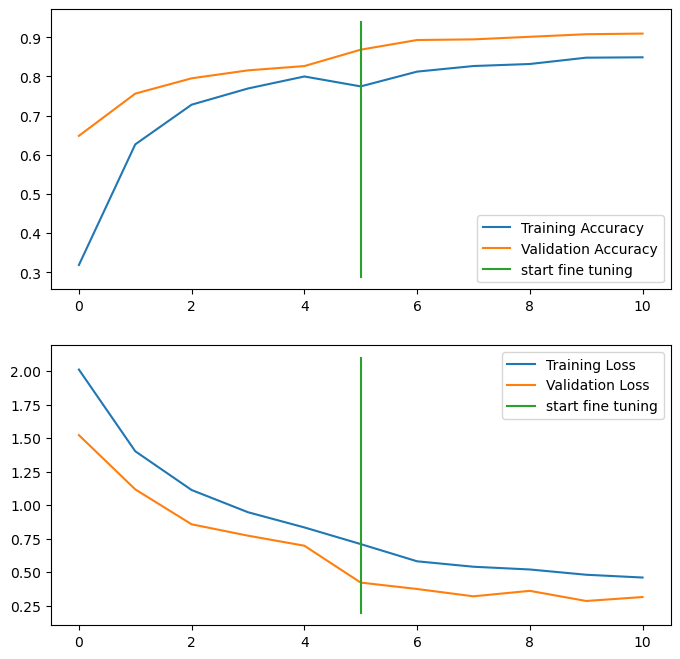

In [139]:
compare_history(history_2, history_4_full)

In [156]:
import numpy as np
print(f"In total, we trained for {history_4_full.epoch[-1]} epochs and achieved an training accuracy of {history_4_full.history['accuracy'][np.argmax(history_4_full.history['accuracy'])] * 100}% and a test accuracy of {history_4_full.history['val_accuracy'][np.argmax(history_4_full.history['val_accuracy'])] * 100}%")

In total, we trained for 9 epochs and achieved an training accuracy of 84.89333391189575% and a test accuracy of 90.95394611358643%


In [180]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)

    # decode the image into 3 channels
    img = tf.image.decode_image(img, channels=3)

    # reshape image to img_shape
    img = tf.image.resize(img, size=[img_shape, img_shape])


    return img



In [162]:
import pathlib
data_dir = pathlib.Path("datasets/10_food_classes_all_data/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [175]:
# create a function to simplify prediction
def get_prediction(model, filename, imgsize=224):
    img = load_and_prep_image(filename, imgsize)
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    label = class_names[pred.argmax()]
    print(class_names)
    print(pred)

    plt.imshow(plt.imread(filename))
    plt.axis(False)
    plt.title(label)
    plt.show()

1/1 [==============================] - 0s 47ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[7.9096848e-05 4.5315865e-06 1.3380061e-04 3.3573549e-05 1.9491346e-05
  4.4425560e-06 9.9961299e-01 4.6962075e-05 2.5209873e-05 4.0010051e-05]]


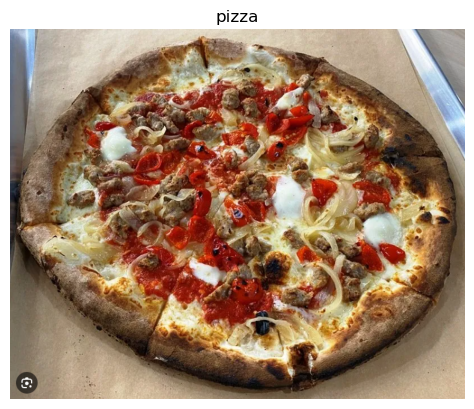

In [181]:
get_prediction(model_3, "datasets/pizza_steak/pizza_steak/eval/steak_test3.png")

1/1 [==============================] - 0s 39ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[2.1533930e-04 6.6346256e-06 7.5110420e-06 3.4202956e-05 3.0895255e-05
  5.8268029e-07 2.8858265e-06 9.9957651e-01 1.2425262e-04 1.1665131e-06]]


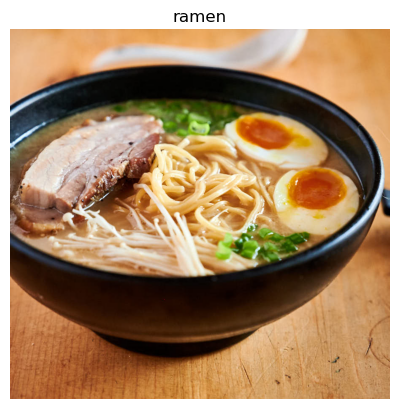

In [182]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/ramen_1.jpg")

1/1 [==============================] - 0s 39ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[9.6664406e-02 2.7088246e-03 7.4812199e-04 5.6128664e-04 4.2127540e-05
  1.4322051e-05 2.0886939e-04 8.9721280e-01 1.8304841e-03 8.6867640e-06]]


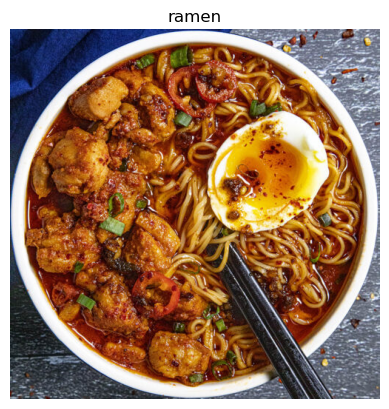

In [186]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/ramen_2.jpg")

1/1 [==============================] - 0s 47ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[7.28263855e-01 1.41548410e-01 8.33327416e-04 4.57199849e-03
  1.89883402e-04 1.49510788e-05 1.37244147e-04 1.21903375e-01
  2.52228114e-03 1.46422653e-05]]


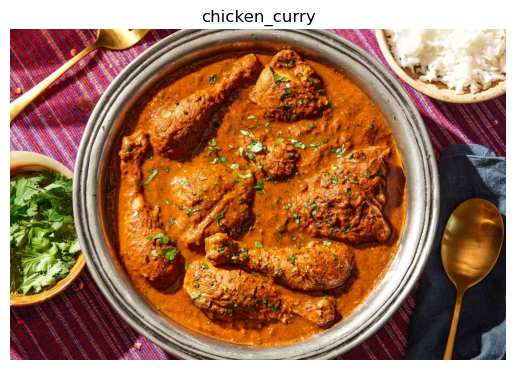

In [187]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/curry_1.jpg")

1/1 [==============================] - 0s 41ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[4.2232861e-07 9.9994326e-01 3.2758976e-09 3.5616617e-05 3.8965684e-08
  1.3079430e-08 5.0557855e-08 5.6436416e-09 2.0155909e-05 3.3917684e-07]]


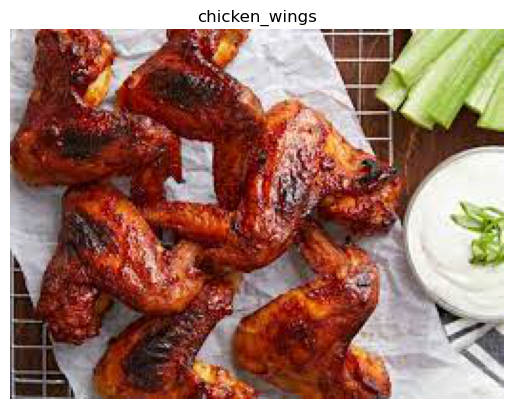

In [188]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/wings_1.jpeg")

1/1 [==============================] - 0s 53ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[8.8436518e-06 1.4799132e-03 2.5726727e-04 2.4207400e-02 4.0492103e-03
  1.2455964e-03 6.7728325e-07 6.1441247e-06 1.2662814e-03 9.6747869e-01]]


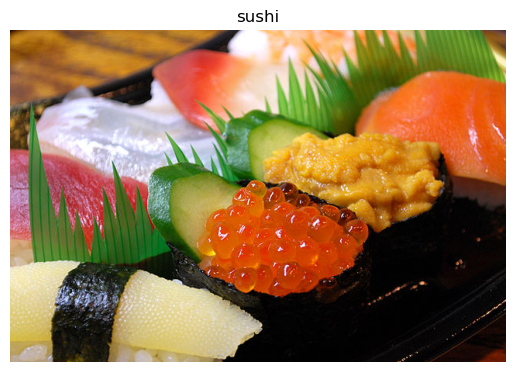

In [189]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/sushi_1.jpg")

1/1 [==============================] - 0s 41ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[6.6157861e-07 6.1880960e-06 2.2296650e-05 7.8649912e-03 9.3155698e-04
  5.9410342e-04 1.1841304e-06 6.4931883e-06 1.9174638e-04 9.9038070e-01]]


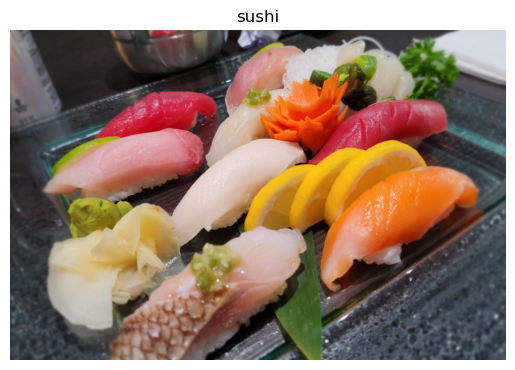

In [190]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/sushi_2.jpg")

1/1 [==============================] - 0s 42ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[0.02405484 0.00466767 0.7841029  0.01580667 0.00702252 0.00360965
  0.00220206 0.13540179 0.01659887 0.0065331 ]]


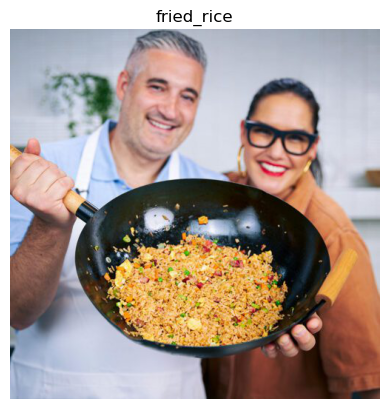

In [191]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/fried_rice_1.jpg")

1/1 [==============================] - 0s 41ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[7.3593021e-03 3.2700836e-03 8.1411970e-05 9.1779131e-01 2.9955276e-03
  9.4298055e-05 5.1030971e-02 7.5690344e-04 8.5931327e-03 8.0270274e-03]]


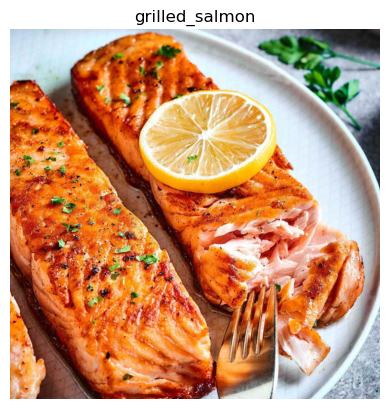

In [193]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/salmon_1.jpg")

1/1 [==============================] - 0s 40ms/step
['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
[[1.5821002e-04 2.4821816e-02 2.1028252e-06 4.6573213e-01 2.2655895e-02
  5.8889065e-05 4.1753624e-04 3.0858223e-06 1.9987168e-04 4.8595050e-01]]


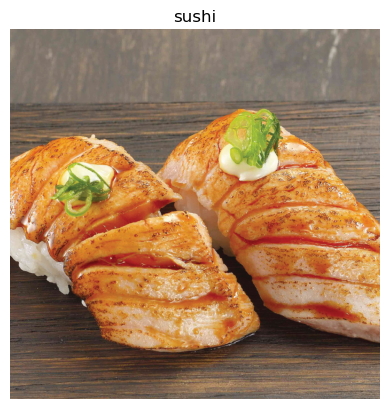

In [194]:
get_prediction(model_3, "datasets/10_food_classes_all_data/eval/salmon and suhsi.jpg")